In [ ]:
import numpy as np
from numba import njit,jit
import sys
import matplotlib.pyplot as plt




dt_model = 5 * 10**(-3) #s  
T_exp = 700 #s #length of the experiment 
time_points = int(T_exp/ dt_model) + 1 

s= 40 #3 neg  #argument that can be put to seed the random number generator
np.random.seed(s)


In [ ]:
# CHEMOTAXIS WITHOUT METHYLATION NOISE




dt_model = 5 * 10**(-3) #s   

T_exp = 700 #s
time_points = int(T_exp/ dt_model) + 1 #the number of time points is different from the number of steps. In the array (0,1,2) 
    #there are 2 steps and 3 points
    #if we wanna include in the count both the edges, because our starting point number is 0 (if it was 1 that is not necessary)

randomness_metnoise = np.random.normal(0,1, size = time_points)

sigma_r = 1
randomness_arrival_rate = np.random.normal(0,sigma_r, size = time_points)

# expressing randomness outside of the numba enviroment to handle properly the random seed and random number generator
phi0_random = np.random.uniform()
theta0_random = np.random.uniform()

randomness_diff_DR = np.zeros((time_points, 3))
randomness_diff_DT = np.zeros((time_points, 3))

z_random = np.zeros(time_points)


for i in range(0, time_points):

    randomness_diff_DR[i] = np.random.normal(0,1,3)

    randomness_diff_DT[i] = np.random.normal(0,1,3)

    z_random[i] = np.random.uniform()



@njit
def crossp_3d(a, b):
    c = [a[1]*b[2] - a[2]*b[1],
         a[2]*b[0] - a[0]*b[2],
         a[0]*b[1] - a[1]*b[0]]

    return c

@njit
def norm_3d(a):
    norm_squared = a[0]**2 + a[1]**2 + a[2]**2
    return np.sqrt(norm_squared)


@njit
def direction_update_with_D_R(p_t, D_R, dt, randomness_DR):

    # p_t vector

    Gamma_p = np.zeros(3) #vector
    p_updated = np.zeros(3)
    coeff = np.sqrt(2 * D_R )

    Gamma_p = np.sqrt(dt) * randomness_DR

    cross_product = crossp_3d(p_t, Gamma_p)

    delta_p = coeff * np.array(cross_product)
    
    p_updated = p_t + delta_p # vector # p_t and delta_p are perpendicular 

    p_updated_norm = norm_3d(p_updated)

    p_updated_normalized = p_updated / p_updated_norm #vector
    
    return p_updated_normalized 


@njit
def direction_update_with_D_T(p_t, D_T, dt, randomness_DT):
    # p_t vector

    Gamma_p = np.zeros(3) #vector
    p_updated = np.zeros(3)
    coeff = np.sqrt(2 * D_T)

    Gamma_p = np.sqrt(dt) * randomness_DT
    
    # this for loop should be equivalent to taking a random sample from a 3D normal distribution 
    # mean = 0
    # cov = np.identity(3) 
    # size = 1 #how many points do u want to get - i need one point (x,y,z) to associate with each componet of Gamma_p
    # Gamma_p = np.sqrt(dt) * np.random.multivariate_normal(mean, cov, size) #np.random.multivariate_normal() is not supported in numba

    cross_product = crossp_3d(p_t, Gamma_p)

    delta_p = coeff * np.array(cross_product)

    p_updated = p_t + delta_p # vector # p_t and delta_p are perpendicular 

    p_updated_norm = norm_3d(p_updated)

    p_updated_normalized = p_updated / p_updated_norm #vector

    return p_updated_normalized


@njit
def conc_gradient_exp(c_0, g, x):
    return  c_0 * np.exp(g*x)

#def signal_update(c_0, c, t, dt): # signal vector has size = size(c) - 1
    #delts_c = c[t] - c[t-1]
    #return (1/c_0)* (delts_c / dt)
#       OR

@njit
def signal_update(v_0, g, dir): 
    return g * v_0 * dir

@njit
def arrival_rate(kappa_D, r_0, dt_model, c, randomness_arr_rate):

    xinoise_value = np.sqrt(r_0)*np.sqrt(dt_model)*randomness_arr_rate

    return kappa_D*(c) + xinoise_value

@njit
def methylation_noise(time_points, dt_model, D_n, tau_n,randomness_metnoise):

    eta_wnoise_value = np.sqrt(2*D_n)*np.sqrt(dt_model)*randomness_metnoise
    met_noise_eta = np.zeros(time_points)
    d_eta = np.zeros(time_points)

    for t in range(0, time_points-1): 

        d_eta[t] = -(1/tau_n)*dt_model*met_noise_eta[t] + eta_wnoise_value[t]

        met_noise_eta[t + 1] = met_noise_eta[t] + d_eta[t]

    return met_noise_eta


@njit
def probability_run_tumble(t, dt, met_noise_eta, rate_r, alpha_Y, w_rate, epsilon_2, epsilon_3, tau_1, tau_2, K_rate, G_r, r_0, a_0):


    t_prior_values = np.arange(0, t + 1)  # All t_prime values from 0 up to t

    # Compute kernel responses for all t_prime values for this t
    exp_term_1 = np.exp(-(1/tau_1) * (t - t_prior_values) * dt)  
    exp_term_2 = np.exp(-(1/tau_2) * (t - t_prior_values) * dt)

    kernel_lin_responses = G_r * ((1/tau_1) * exp_term_1 - (1/tau_2) * exp_term_2)

    rate_diffs = rate_r - r_0 #rate differences

    increments = kernel_lin_responses * rate_diffs * dt #vector size of t_prime_values
    int_lin_response = np.sum(increments) # sum up all increments for this t 

    activity_a = a_0 - int_lin_response # + met_noise_eta[t]

    #   concentration of the response regulator CheY-P
    Y_conc_CheYP = alpha_Y*activity_a

    #   motor (?)
    G_Y = (epsilon_2/4) - (epsilon_3/2) * (Y_conc_CheYP / (Y_conc_CheYP + K_rate))

    #  switching rates
    lambda_R = w_rate*np.exp(-G_Y)
    lambda_T = w_rate*np.exp(+G_Y)
    

    #probability to be running (steady state case)
    #prob_r = lambda_T / (lambda_T + lambda_R) 

    #probability to continue running after t + dt (Poisson process)
    prob_survival = 1 - lambda_R * dt

    #probability to switch from tumble to run
    prob_t_to_r = lambda_T * dt

    return Y_conc_CheYP, lambda_R, lambda_T, activity_a, prob_survival, prob_t_to_r 

# define a function that eliminates the duplicates values of x that are reported when the bacterium tumbles (which means it is at x still)



@njit
def chemotaxis(dt_model,time_points,phi0_random,theta0_random,randomness_diff_DR,randomness_diff_DT,randomness_arrival_rate,z_random,randomness_metnoise):
    

    #CONCENTRATION - SIGNAL
    #conc_c = np.zeros((N_time_points, 1))
    c_0 = 1  #muM
    kappa_D = 1.2*(10**5) #s-1 muM-1

    #ARRIVAL RATE
    #rate_r = np.zeros((N_time_points, 1))
    #rate_r[0] = 
    r_0 = kappa_D*c_0 #s-1
    
    g = 0.1 * 10**(-3) # micrometers-1 (1 micro m = 10^-3 mm)
    v_0 = 20 # micrometers / s : maximal run speed is 20 microm / s

    #ACTIVITY
    #activity_a = np.zeros((N_time_points, 1))
    a_0 = 1/3
    tau_1 = 0.35 #s
    tau_2 = 7.4 #s
    G_r = (1/kappa_D)*2.28

    #METHYLATION NOISE
    D_n = 8.1 *(10**(-4))#+/- 0.9 x 10-4 ??? #s-1
    tau_n = 8.7 #s


    #PARAMETERS

    alpha_Y = 6 #microM
    w_rate = 1.3 #s-1
    epsilon_2 = 40
    epsilon_3 = 40
    K_rate = 3.06 #microM

    #ROTATIONAL DIFFUSION
    D_R = 0.062 # s-1  std = 0.03 s-1
    D_T = 37 * D_R 

    
    met_noise_eta = methylation_noise(time_points, dt_model, D_n, tau_n,randomness_metnoise)

    logic_run_tumble = [] # logic vector: for each time step 1-running 0-tumbling

    dirx_run = []
    dirx_run.append(0)

    position_X = [] #np.zeros(N_time_points) #X position - changes after every run
    position_X.append(0)  # Initialize the first position, starting position (0,0)

    signal_s = []
    signal_s.append(0) # how to initialize the signal

    conc_c = []
    conc_c.append(c_0)

    rate_r = []
    rate_r.append(r_0)

    activity_a = []
    activity_a.append(a_0) 

    x = 0
    dirx_run = [] #directiona along x - changes with every tumble - is the same for consecutive runs

    t_length_each_run = [] # time-lenght of each run
    t_length_each_tumble = [] # time-lenght of each tumble

    num_runs = 0
    index_time = 0
    t_model = []
    t_model.append(index_time) # so t_model has units of index! 

    theta_0 =2*np.pi * theta0_random
    phi_0 = 2*np.pi * phi0_random

    dirx_run_updated = np.cos(theta_0) * np.cos(phi_0)
    dir_3d = [dirx_run_updated, np.cos(theta_0) * np.sin(phi_0), np.sin(theta_0)]
    dir_3d = np.array(dir_3d)

    run_after_tumble_idx = 0 # the first redirection happens with D_R

    j1 = 0
    j2 = 1

    length_single_run = 0 # length in time units of each single run
    length_single_tumble = 0
        

    for index_time in range(1, time_points):

        t_model.append(index_time) #update the time (which keeps running btw)

        if j1 < 1:

            num_runs += 1

            length_single_run += dt_model # it starts with a run from 0 to dt

            logic_run_tumble.append(1)

            run_after_tumble_idx += 1

            if run_after_tumble_idx > 1: 

                dir_3d = direction_update_with_D_R(dir_3d, D_R, dt_model, randomness_diff_DR[index_time])
                dirx_run_updated = dir_3d[0] # x component
                dirx_run.append(dirx_run_updated)


            x += dirx_run_updated*v_0*dt_model
            position_X.append(x)

            conc_c_updated = conc_gradient_exp(c_0, g, x) #updated concentration
            conc_c.append(conc_c_updated)

            signal_s_updated = signal_update(v_0, g, dirx_run_updated)
            signal_s.append(signal_s_updated)

            rate_r_updated = arrival_rate(kappa_D, r_0, dt_model, conc_c_updated, randomness_arrival_rate[index_time])
            rate_r.append(rate_r_updated)
            
            # make sure to pass arrays to a fuction otherwise it will create errors with numba
            Y_conc_CheYP, lambda_R, _, activity_a_updated, prob_survival, prob_t_to_r = probability_run_tumble(index_time, 
                            dt_model, met_noise_eta, np.array(rate_r), alpha_Y, w_rate, epsilon_2, epsilon_3, tau_1, tau_2, K_rate, G_r, r_0, a_0)

            
            activity_a.append(activity_a_updated)

            
            

            if prob_survival < z_random[index_time]: #if the prob to run is smaller than the random number then it tumbles
                t_length_each_run.append(length_single_run)
                
                j1 = 1
                j2 = 0 
                length_single_run = 0

                continue # skip the rest of the loop and starts a new iteration


        if j2 < 1:
            
            length_single_tumble += dt_model

        
            # signal and conc stays the same (same position)
            position_X.append(x)
            conc_c.append(conc_c_updated)

            logic_run_tumble.append(0)

            #redirection after each tumbling ? 
            dir_3d = direction_update_with_D_T(dir_3d, D_T, dt_model, randomness_diff_DT[index_time])
            dirx_run_updated = dir_3d[0] # x component 

            dirx_run.append(0)
            signal_s.append(0) # signal during tumbling goes to 0

            #update again the rate and activity and probability becasue of noise they can still change
            rate_r_updated = arrival_rate(kappa_D, r_0, dt_model, conc_c_updated, randomness_arrival_rate[index_time])
            rate_r.append(rate_r_updated)
            
            Y_conc_CheYP, _, lambda_T, activity_a_updated, _ , prob_t_to_r = probability_run_tumble(index_time, 
                            dt_model, met_noise_eta, np.array(rate_r), alpha_Y, w_rate, epsilon_2, epsilon_3, tau_1, tau_2, K_rate, G_r, r_0, a_0)

            activity_a.append(activity_a_updated)
            

            if prob_t_to_r > z_random[index_time]: 
                t_length_each_tumble.append(length_single_tumble)
                length_single_tumble = 0

                #dirx_run_updated = dirx_run_updated + functions.direction_x_update_with_D_T(D_T, dt_model) # running direction from a tumbling state
                dirx_run.append(dirx_run_updated)
                run_after_tumble_idx = 0
                
                j2 = 1 
                j1 = 0

                continue
    
    # at the end of the loop the bacteria might still be running or tumbling, so there is still need to append those values
    if j1 < 1 and length_single_run > 0:
        t_length_each_run.append(length_single_run)

    if j2 < 1 and length_single_tumble > 0:
        t_length_each_tumble.append(length_single_tumble)

    # Ensure t_model is a NumPy array
    t_model = np.array(t_model)
    t_model1 = t_model * dt_model #to get the right time intervals
    # total_time_exp = index_time * dt_model


    # average_running_time = np.mean(t_length_each_run)
    # average_tumbling_time = np.mean(t_length_each_tumble)
    
    t_length_each_run = np.array(t_length_each_run)
    total_running_time = np.sum(t_length_each_run) 
    
    t_length_each_tumble = np.array(t_length_each_tumble)
    

    position_X = np.array(position_X)
    total_x_travelled = position_X[-1] - position_X[0]



    drift_speed = total_x_travelled / total_running_time

    #v_x for each run
    v_x_with0s = (position_X[:-1] - position_X[1:] ) / dt_model
    # v_x = (position_x_noduplicates[1:] - position_x_noduplicates[:-1]) / dt_model


    return r_0, a_0, t_model1, time_points, drift_speed, position_X, v_x_with0s, activity_a, signal_s, rate_r, t_length_each_run, t_length_each_tumble


r0, a0, t_model1, num_points_xt, v_d, pos_x, v_x_with0, activity_a, signal_s, rate_r, t_length_each_run, t_length_each_tumble = chemotaxis(dt_model,time_points,phi0_random,
                                                  theta0_random,randomness_diff_DR,randomness_diff_DT,randomness_arrival_rate,z_random, randomness_metnoise)



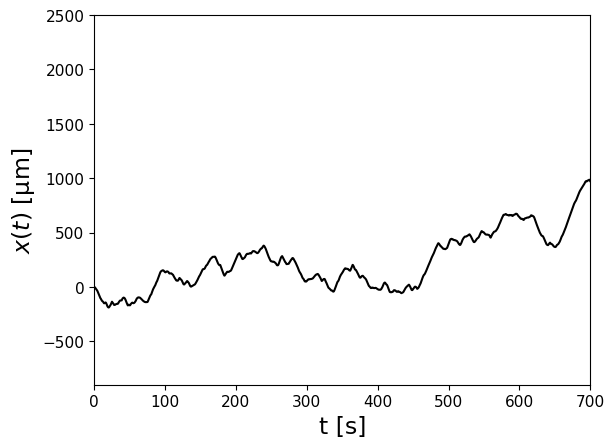

In [ ]:
# Plotting trajectory, model realization



plt.figure()
plt.plot(t_model1, pos_x, 'k', label='NO met noise')
#plt.plot(t_model1, pos_x_wmet, color="#F6782A", label='WITH met noise')
#plt.plot(t_model1, -pos_x_wmet, color="r", label='WITH met noise')
plt.xlabel('t [s]', fontsize=17)
plt.ylabel(r'$x(t)$ [μm]', fontsize=17)
plt.xlim([0, max(t_model1)])
plt.ylim([-900, 2500])
plt.tick_params(axis='both', which='major', labelsize=11)  # Bigger tick labels
#plt.legend(loc='upper left')
plt.show()

In [4]:
# CHEMOTAXIS WITH METNOISE


@njit
def probability_run_tumble(t, dt, met_noise_eta, rate_r, alpha_Y, w_rate, epsilon_2, epsilon_3, tau_1, tau_2, K_rate, G_r, r_0, a_0):


    t_prior_values = np.arange(0, t + 1)  # All t_prime values from 0 up to t

    # Compute kernel responses for all t_prime values for this t
    exp_term_1 = np.exp(-(1/tau_1) * (t - t_prior_values) * dt)  
    exp_term_2 = np.exp(-(1/tau_2) * (t - t_prior_values) * dt)

    kernel_lin_responses = G_r * ((1/tau_1) * exp_term_1 - (1/tau_2) * exp_term_2)

    rate_diffs = rate_r - r_0 #rate differences

    increments = kernel_lin_responses * rate_diffs * dt #vector size of t_prime_values
    int_lin_response = np.sum(increments) # sum up all increments for this t 

    activity_a = a_0 - int_lin_response #+ met_noise_eta[t]

    #   concentration of the response regulator CheY-P
    Y_conc_CheYP = alpha_Y*activity_a

    #   motor (?)
    G_Y = (epsilon_2/4) - (epsilon_3/2) * (Y_conc_CheYP / (Y_conc_CheYP + K_rate))

    #  switching rates
    lambda_R = w_rate*np.exp(-G_Y)
    lambda_T = w_rate*np.exp(+G_Y)
    

    #probability to be running (steady state case)
    #prob_r = lambda_T / (lambda_T + lambda_R) 

    #probability to continue running after t + dt (Poisson process)
    prob_survival = 1 - lambda_R * dt

    #probability to switch from tumble to run
    prob_t_to_r = lambda_T * dt

    return Y_conc_CheYP, lambda_R, lambda_T, activity_a, prob_survival, prob_t_to_r 

@njit
def chemotaxis(dt_model,time_points,phi0_random,theta0_random,randomness_diff_DR,randomness_diff_DT,randomness_arrival_rate,z_random,randomness_metnoise):
    

    #CONCENTRATION - SIGNAL
    #conc_c = np.zeros((N_time_points, 1))
    c_0 = 1  #muM
    kappa_D = 1.2*(10**5) #s-1 muM-1

    #ARRIVAL RATE
    #rate_r = np.zeros((N_time_points, 1))
    #rate_r[0] = 
    r_0 = kappa_D*c_0 #s-1
    
    g = 0.3 * 10**(-3) # micrometers-1 (1 micro m = 10^-3 mm)
    v_0 = 20 # micrometers / s : maximal run speed is 20 microm / s

    #ACTIVITY
    #activity_a = np.zeros((N_time_points, 1))
    a_0 = 1/3
    tau_1 = 0.35 #s
    tau_2 = 7.4 #s
    G_r = (1/kappa_D)*2.28

    #METHYLATION NOISE
    D_n = 8.1 *(10**(-4))#+/- 0.9 x 10-4 ??? #s-1
    tau_n = 8.7 #s


    #PARAMETERS

    alpha_Y = 6 #microM
    w_rate = 1.3 #s-1
    epsilon_2 = 40
    epsilon_3 = 40
    K_rate = 3.06 #microM

    #ROTATIONAL DIFFUSION
    D_R = 0.062 # s-1  std = 0.03 s-1
    D_T = 37 * D_R 

    
    met_noise_eta = methylation_noise(time_points, dt_model, D_n, tau_n,randomness_metnoise)

    logic_run_tumble = [] # logic vector: for each time step 1-running 0-tumbling

    dirx_run = []
    dirx_run.append(0)

    position_X = [] #np.zeros(N_time_points) #X position - changes after every run
    position_X.append(0)  # Initialize the first position, starting position (0,0)

    signal_s = []
    signal_s.append(0) # how to initialize the signal

    conc_c = []
    conc_c.append(c_0)

    rate_r = []
    rate_r.append(r_0)

    activity_a = []
    activity_a.append(a_0) 

    x = 0
    dirx_run = [] #directiona along x - changes with every tumble - is the same for consecutive runs

    t_length_each_run = [] # time-lenght of each run
    t_length_each_tumble = [] # time-lenght of each tumble

    num_runs = 0
    index_time = 0
    t_model = []
    t_model.append(index_time) # so t_model has units of index! 

    theta_0 =2*np.pi * theta0_random
    phi_0 = 2*np.pi * phi0_random

    dirx_run_updated = np.cos(theta_0) * np.cos(phi_0)
    dir_3d = [dirx_run_updated, np.cos(theta_0) * np.sin(phi_0), np.sin(theta_0)]
    dir_3d = np.array(dir_3d)

    run_after_tumble_idx = 0 # the first redirection happens with D_R

    j1 = 0
    j2 = 1

    length_single_run = 0 # length in time units of each single run
    length_single_tumble = 0
        

    for index_time in range(1, time_points):

        t_model.append(index_time) #update the time (which keeps running btw)

        if j1 < 1:

            num_runs += 1

            length_single_run += dt_model # it starts with a run from 0 to dt

            logic_run_tumble.append(1)

            run_after_tumble_idx += 1

            if run_after_tumble_idx > 1: 

                dir_3d = direction_update_with_D_R(dir_3d, D_R, dt_model, randomness_diff_DR[index_time])
                dirx_run_updated = dir_3d[0] # x component
                dirx_run.append(dirx_run_updated)


            x += dirx_run_updated*v_0*dt_model
            position_X.append(x)

            conc_c_updated = conc_gradient_exp(c_0, g, x) #updated concentration
            conc_c.append(conc_c_updated)

            signal_s_updated = signal_update(v_0, g, dirx_run_updated)
            signal_s.append(signal_s_updated)

            rate_r_updated = arrival_rate(kappa_D, r_0, dt_model, conc_c_updated, randomness_arrival_rate[index_time])
            rate_r.append(rate_r_updated)
            
            # make sure to pass arrays to a fuction otherwise it will create errors with numba
            Y_conc_CheYP, lambda_R, _, activity_a_updated, prob_survival, prob_t_to_r = probability_run_tumble(index_time, 
                            dt_model, met_noise_eta, np.array(rate_r), alpha_Y, w_rate, epsilon_2, epsilon_3, tau_1, tau_2, K_rate, G_r, r_0, a_0)

            
            activity_a.append(activity_a_updated)

            
            

            if prob_survival < z_random[index_time]: #if the prob to run is smaller than the random number then it tumbles
                t_length_each_run.append(length_single_run)
                
                j1 = 1
                j2 = 0 
                length_single_run = 0

                continue # skip the rest of the loop and starts a new iteration


        if j2 < 1:
            
            length_single_tumble += dt_model

        
            # signal and conc stays the same (same position)
            position_X.append(x)
            conc_c.append(conc_c_updated)

            logic_run_tumble.append(0)

            #redirection after each tumbling ? 
            dir_3d = direction_update_with_D_T(dir_3d, D_T, dt_model, randomness_diff_DT[index_time])
            dirx_run_updated = dir_3d[0] # x component 

            dirx_run.append(0)
            signal_s.append(0) # signal during tumbling goes to 0

            #update again the rate and activity and probability becasue of noise they can still change
            rate_r_updated = arrival_rate(kappa_D, r_0, dt_model, conc_c_updated, randomness_arrival_rate[index_time])
            rate_r.append(rate_r_updated)
            
            Y_conc_CheYP, _, lambda_T, activity_a_updated, _ , prob_t_to_r = probability_run_tumble(index_time, 
                            dt_model, met_noise_eta, np.array(rate_r), alpha_Y, w_rate, epsilon_2, epsilon_3, tau_1, tau_2, K_rate, G_r, r_0, a_0)

            activity_a.append(activity_a_updated)
            

            if prob_t_to_r > z_random[index_time]: 
                t_length_each_tumble.append(length_single_tumble)
                length_single_tumble = 0

                #dirx_run_updated = dirx_run_updated + functions.direction_x_update_with_D_T(D_T, dt_model) # running direction from a tumbling state
                dirx_run.append(dirx_run_updated)
                run_after_tumble_idx = 0
                
                j2 = 1 
                j1 = 0

                continue
    
    # at the end of the loop the bacteria might still be running or tumbling, so there is still need to append those values
    if j1 < 1 and length_single_run > 0:
        t_length_each_run.append(length_single_run)

    if j2 < 1 and length_single_tumble > 0:
        t_length_each_tumble.append(length_single_tumble)

    # Ensure t_model is a NumPy array
    t_model = np.array(t_model)
    t_model1 = t_model * dt_model #to get the right time intervals
    # total_time_exp = index_time * dt_model


    # average_running_time = np.mean(t_length_each_run)
    # average_tumbling_time = np.mean(t_length_each_tumble)
    
    t_length_each_run = np.array(t_length_each_run)
    total_running_time = np.sum(t_length_each_run) 
    
    t_length_each_tumble = np.array(t_length_each_tumble)
    

    position_X = np.array(position_X)
    total_x_travelled = position_X[-1] - position_X[0]



    drift_speed = total_x_travelled / total_running_time

    #v_x for each run
    v_x_with0s = (position_X[:-1] - position_X[1:] ) / dt_model
    # v_x = (position_x_noduplicates[1:] - position_x_noduplicates[:-1]) / dt_model


    return r_0, a_0, t_model1, time_points, drift_speed, position_X, v_x_with0s, activity_a, signal_s, rate_r, t_length_each_run, t_length_each_tumble


r0, a0, t_model1, num_points_xt, v_d_wmet, pos_x_wmet, v_x_with0_wmet, activity_a_wmet, signal_s_wmet, rate_r_wmet, t_length_each_run_wmet, t_length_each_tumble_wmet = chemotaxis(dt_model,time_points,phi0_random,
                                                  theta0_random,randomness_diff_DR,randomness_diff_DT,randomness_arrival_rate,z_random, randomness_metnoise)



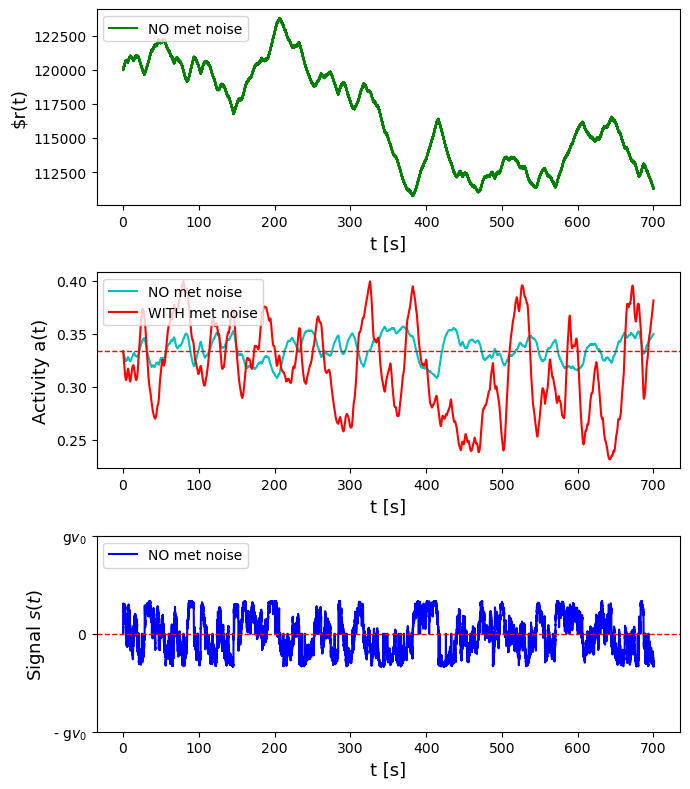

In [ ]:
# Plotting all together trajectory, activity , signal



plt.figure(figsize=(7, 8))
plt.subplot(3, 1, 1)  # 2 rows, 1 column, 1st plot

plt.plot(t_model1, rate_r, color='g', label='NO met noise')
#plt.plot(t_model1, pos_x_wmet, 'r', label='WITH met noise')
plt.xlabel('t [s]', fontsize=13)
plt.ylabel(r'$r(t)', fontsize=13)
#plt.xlim([470, 490])#plt.xlim([0, max(t_model1)])
#plt.ylim([rate_r_nom[470], rate_r_nom[490]])
plt.legend(loc='upper left')

plt.subplot(3, 1, 2)
plt.plot(t_model1, activity_a, color='c', label='NO met noise')
plt.plot(t_model1, activity_a_wmet, 'r', label='WITH met noise')
plt.axhline(y=a0, color='r', linestyle='--', linewidth=1)
plt.xlabel('t [s]', fontsize=13)
plt.ylabel(r'Activity a(t)', fontsize=13)
#plt.xlim([470, 490])#plt.xlim([0, max(t_model1)])
#plt.ylim([0,10])
plt.legend(loc='upper left')
#plt.yticks([a0], [ r'$a_0$'])

plt.subplot(3, 1, 3)
plt.plot(t_model1, signal_s, color='b', label='NO met noise')
#plt.plot(t_model1, signal_s_wmet, 'r', label='WITH met noise')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel('t [s]', fontsize=13)
plt.ylabel(r'Signal $s(t)$', fontsize=13)
#plt.xlim([470, 490])
plt.legend(loc='upper left')
plt.yticks([0.006, 0, -0.006], [r'g$v_0$', r'$0$', r'- g$v_0$'])


plt.tight_layout()
plt.show()

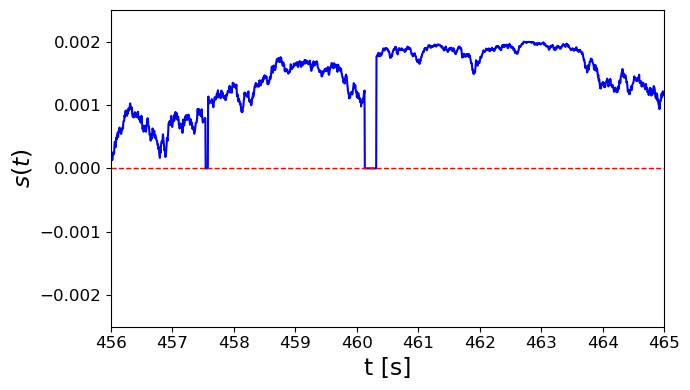

In [ ]:
# Plotting signal in a specified time interval



plt.figure(figsize=(7,4))

plt.plot(t_model1, signal_s, color='b', label='NO met noise')
#plt.plot(t_model1, signal_s_wmet, 'r', label='WITH met noise')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel('t [s]', fontsize=17)
plt.ylabel(r'$s(t)$', fontsize=17)

plt.xlim([456,465])
#plt.ylim([-0.0065, 0.0065])
plt.ylim([-0.0025, 0.0025])
#plt.legend(loc='upper left')
#plt.yticks([0.006, 0, -0.006], [r'g$v_0$', r'$0$', r'- g$v_0$'])

plt.tick_params(axis='both', which='major', labelsize=12) 

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from numba import njit

rate_r_nom = np.array(rate_r)

# num of random noise realizations to add to activity to generate different curves
N_curves = 5


# Generate multiple randomness_metnoise arrays, one per curve
randomness_metnoise = np.zeros((N_curves, time_points))
for j in range(N_curves):
    ss=30 + j #int(sys.argv[1]) #an argument that can be put to seed the random number generator
    np.random.seed(ss)
    randomness_metnoise[j] = np.random.normal(0, 1, size=time_points)



In [8]:

@njit
def methylation_noise(time_points, dt_model, D_n, tau_n, randomness_metnoise0):
    eta_wnoise_value = np.sqrt(2*D_n)*np.sqrt(dt_model)*randomness_metnoise0
    met_noise_eta = np.zeros(time_points)
    d_eta = np.zeros(time_points)
    for t in range(time_points - 1):
        d_eta[t] = -(1/tau_n)*dt_model*met_noise_eta[t] + eta_wnoise_value[t]
        met_noise_eta[t + 1] = met_noise_eta[t] + d_eta[t]
    return met_noise_eta

@njit
def activ_update(t, dt, met_noise_eta, rate_r, alpha_Y, w_rate, epsilon_2, epsilon_3, tau_1, tau_2, K_rate, G_r, r_0, a_0):
    t_prior_values = np.arange(0, t + 1)
    exp_term_1 = np.exp(-(1/tau_1) * (t - t_prior_values) * dt)
    exp_term_2 = np.exp(-(1/tau_2) * (t - t_prior_values) * dt)
    kernel_lin_responses = G_r * ((1/tau_1) * exp_term_1 - (1/tau_2) * exp_term_2)
    rate_diffs = rate_r - r_0
    increments = kernel_lin_responses * rate_diffs * dt
    int_lin_response = np.sum(increments)
    activity_a = a_0 - int_lin_response + met_noise_eta[t]
    return activity_a

@njit
def chemotaxis(rate_r_nom, dt_model, time_points, randomness_metnoise0):
    c_0 = 1
    kappa_D = 1.2*(10**5)
    r_0 = kappa_D * c_0
    a_0 = 1/3
    tau_1 = 0.35
    tau_2 = 7.4
    G_r = (1/kappa_D)*2.28
    D_n = 8.1 * (10**(-4))
    tau_n = 8.7
    alpha_Y = 6
    w_rate = 1.3
    epsilon_2 = 40
    epsilon_3 = 40
    K_rate = 3.06

    met_noise_eta = methylation_noise(time_points, dt_model, D_n, tau_n, randomness_metnoise0)

    activity_a = np.empty(time_points)
    activity_a[0] = a_0

    for index_time in range(1, time_points):
        activity_a[index_time] = activ_update(
            index_time, dt_model, met_noise_eta, rate_r_nom[index_time], alpha_Y, w_rate,
            epsilon_2, epsilon_3, tau_1, tau_2, K_rate, G_r, r_0, a_0)

    return activity_a


In [ ]:
# Run chemotaxis for each randomness_metnoise curve (fluctuations in activity, bottom right plot in sebsequent figure)



activity_a_wmet = []

for j in range(N_curves):
    activity = chemotaxis(rate_r_nom, dt_model, time_points, randomness_metnoise[j])
    activity_a_wmet.append(activity)


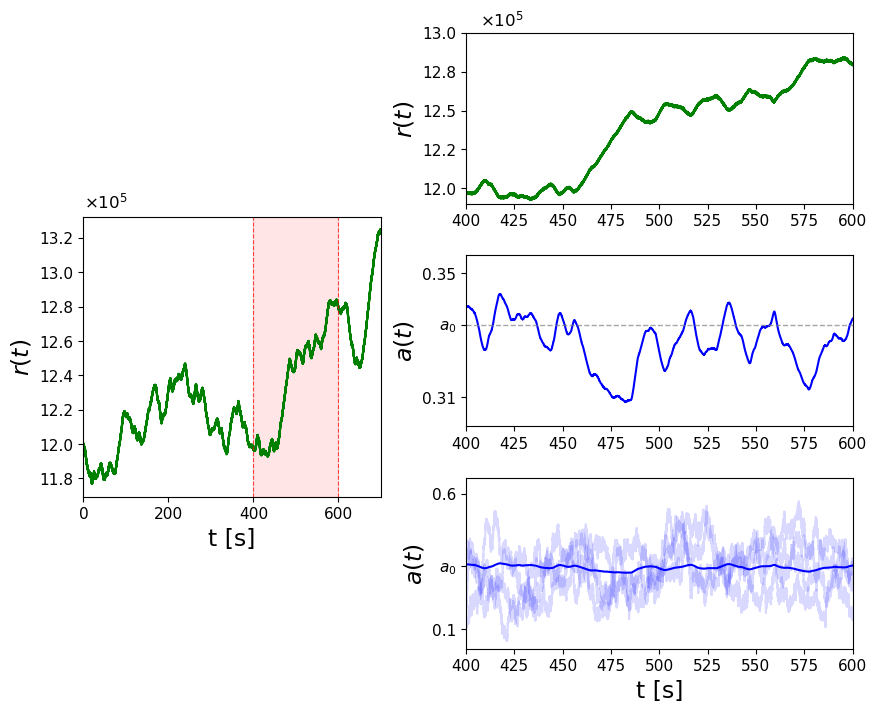

In [ ]:
# Plotting the ligand arrival rate r(t) and kinase response to r(t) with and without methylation noise



import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8.5, 8))  # overall canvas size

# left plot (rate trajectory)
ax0 = fig.add_axes([0.05, 0.30, 0.35, 0.35])  # left, bottom, width, height
ax0.plot(t_model1, rate_r_nom, color='g', label='NO met noise')
ax0.set_xlabel('t [s]', fontsize=17)
ax0.set_ylabel(r'$r(t)$', fontsize=17)
ax0.set_xlim([0,700])
ax0.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*1e-4:.1f}"))
ax0.yaxis.offsetText.set_visible(False)
ax0.text(0.15, 1.02, r'$\times 10^5$', transform=ax0.transAxes, ha='right', va='bottom', fontsize=12)
ax0.tick_params(axis='both', which='major', labelsize=11)

# Add vertical lines and shaded region
ax0.axvline(400, color='red', linestyle='--', alpha=0.7, linewidth=0.8)
ax0.axvline(600, color='red', linestyle='--', alpha=0.7, linewidth=0.8)
ax0.axvspan(400, 600, color='red', alpha=0.1)

# GridSpec with 3 rows for right column
gs = fig.add_gridspec(3, 1, left=0.5, right=0.955, height_ratios=[1,1,1], hspace=0.3)

# ax1: top-right (rate zoomed in)
ax1 = fig.add_subplot(gs[0])
ax1.plot(t_model1, rate_r_nom, color='g', label='NO met noise')
ax1.set_xlim([400,600]) #([455, 490])
ax1.set_ylim([119000, 130000])
ax1.set_ylabel(r'$r(t)$', fontsize=17)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*1e-4:.1f}"))
ax1.yaxis.offsetText.set_visible(False)
ax1.text(0.15, 1.02, r'$\times 10^5$', transform=ax1.transAxes, ha='right', va='bottom', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=11)

# ax_middle: middle-right plot (activity deterministic)
ax_middle = fig.add_subplot(gs[1])
ax_middle.plot(t_model1, activity_a, color='b', label='NO met noise')  # replace with your actual data
ax_middle.set_xlim([400,600])
ax_middle.set_ylabel(r'$a(t)$', fontsize=17)
ax_middle.set_yticks([0.31, 1/3, 0.35])
ax_middle.set_yticklabels([0.31, r'$a_0$',0.35])
ax_middle.tick_params(axis='both', which='major', labelsize=11)
ax_middle.axhline(1/3, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# ax2: bottom-right (activity + methylation noise)
ax2 = fig.add_subplot(gs[2])
ax2.plot(t_model1, activity_a, color='b', label='NO met noise')
for j in [0,1,3,4]: #range(3): 
    ax2.plot(t_model1, activity_a_wmet[j], color='b', alpha=0.15)
ax2.set_xlim([400,600]) 
#ax2.set_ylim([0.1, 0.6])
ax2.set_xlabel('t [s]', fontsize=17)
ax2.set_ylabel(r'$a(t)$', fontsize=17)
ax2.set_yticks([0.1, 1/3, 0.6])
ax2.set_yticklabels([0.1, r'$a_0$',0.6])
ax2.tick_params(axis='both', which='major', labelsize=11)

plt.show()



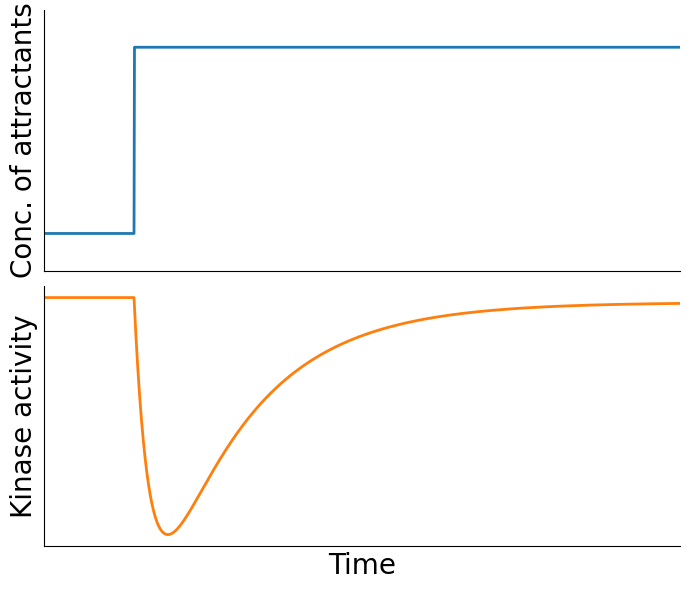

In [ ]:
# Plotting the activity response to step change inconcentration



# Parameters
dt = 0.01          # time step (s)
T = 14.0           # total simulation time (s)
timesteps = int(T / dt)

tau_1 = 0.35       # kernel time constant 1 (s)
tau_2 = 2.0        # kernel time constant 2 (s)
G_r = 1.0          # gain
a_0 = 1.0          # baseline activity
r_0 = 0.0          # baseline rate

# Step input parameters
t_step = 2.0       # time when step occurs (s)
r_step_value = 1.0 # rate value after step

# Initialize rate array: zero before t_step, r_step_value after
rate_r = np.zeros(timesteps)
rate_r[int(t_step / dt):] = r_step_value

# Initialize activity array
activity = np.zeros(timesteps)

# Compute activity over time
for t in range(timesteps):
    t_prior_values = np.arange(0, t + 1)
    time_diffs = (t - t_prior_values) * dt

    exp_term_1 = np.exp(-(1 / tau_1) * time_diffs)
    exp_term_2 = np.exp(-(1 / tau_2) * time_diffs)

    kernel_lin_responses = G_r * ((1 / tau_1) * exp_term_1 - (1 / tau_2) * exp_term_2)
    rate_diffs = rate_r[t_prior_values] - r_0

    increments = kernel_lin_responses * rate_diffs * dt
    int_lin_response = np.sum(increments)

    activity[t] = a_0 - int_lin_response

# Time vector for plotting
time = np.arange(timesteps) * dt

# Plot rate and activity in stacked graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

# Top plot: step input rate
ax1.plot(time, rate_r, color='tab:blue', linewidth=2)
ax1.set_ylabel('Conc. of attractants', fontsize=20)
#ax1.set_title('Step Input')
ax1.set_xticks([])  # remove x ticks
ax1.set_yticks([])
ax1.set_xlim([0,14])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim([-0.2,1.2])

# Bottom plot: activity response
ax2.plot(time, activity, color='tab:orange', linewidth=2)
ax2.set_ylabel('Kinase activity', fontsize=20)
ax2.set_xlabel('Time', fontsize=20)
#ax2.set_title('Activity Response')
ax2.set_xticks([])  # remove x ticks
ax2.set_yticks([])
ax2.set_xlim([0,14])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


plt.tight_layout()
plt.show()


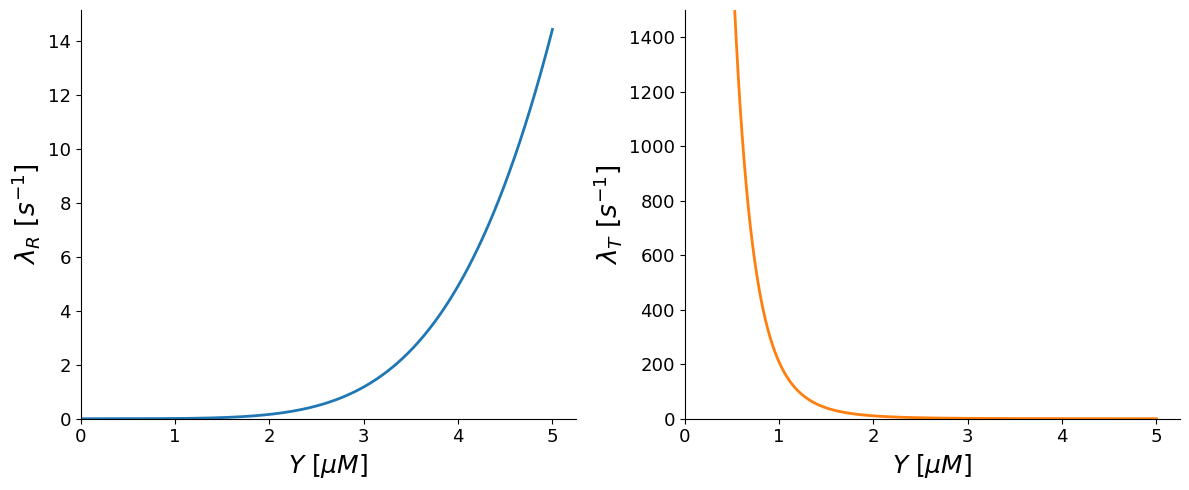

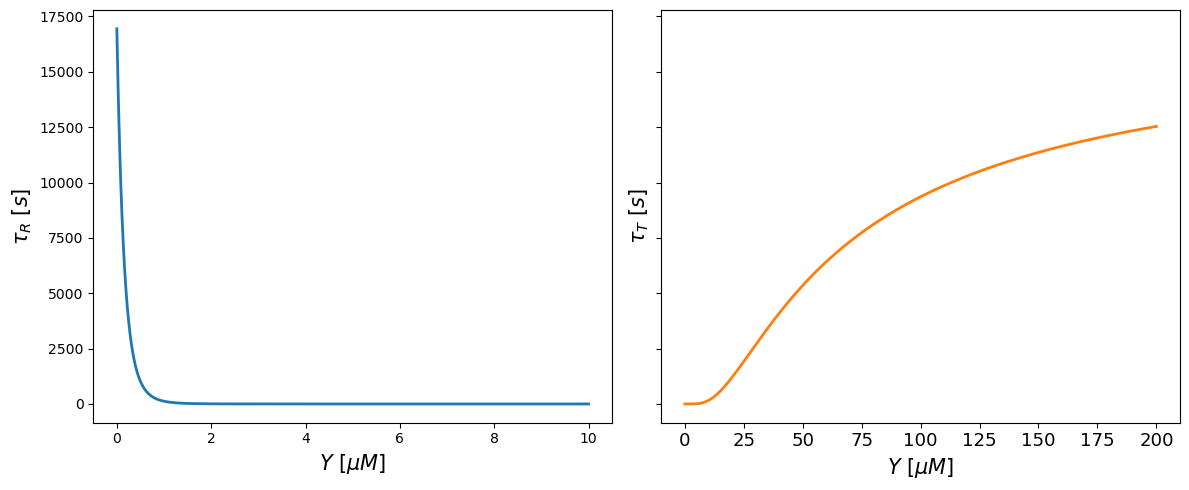

In [ ]:
# Plotting the switching rates as a function of CheY-P concentration Y



# Parameters
w_rate = 1.3       # s^-1
epsilon_2 = 40
epsilon_3 = 40
K_rate = 3.06      # microM

# Define che_y concentration range (e.g., 0 to 20 microM)
che_y1 = np.linspace(0, 5, 4000)
che_y2 = np.linspace(0, 5, 4000)

# Functions to compute lambda_R and lambda_T separately
def compute_lambda_R(che_y):
    G_Y = (epsilon_2 / 4) - (epsilon_3 / 2) * (che_y / (che_y + K_rate))
    return w_rate * np.exp(-G_Y)

def compute_lambda_T(che_y):
    G_Y = (epsilon_2 / 4) - (epsilon_3 / 2) * (che_y / (che_y + K_rate))
    return w_rate * np.exp(+G_Y)

# Compute values for each graph
lambda_R_vals = compute_lambda_R(che_y2)
lambda_T_vals = compute_lambda_T(che_y1)

# Plotting side by side with separate equations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5)) #, sharey=True)

# Plot lambda_R
ax1.plot(che_y2, lambda_R_vals, color='tab:blue', linewidth=2)
#ax1.set_title(r'$\lambda_R$ vs $che\_y$')
ax1.set_xlabel(r'$Y$ [$\mu M$]', fontsize=18)
ax1.set_ylabel(r'$\lambda_R$ [$s^{-1}$]', fontsize=19)
#ax1.set_xticks([])  # remove x ticks
#ax1.set_yticks([])
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=13)  # Bigger tick labels

#ax1.grid(True)

# Plot lambda_T
ax2.plot(che_y1, lambda_T_vals, color='tab:orange', linewidth=2)
#ax2.set_title(r'$\lambda_T$ vs $che\_y$')
ax2.set_ylabel(r'$\lambda_T$ [$s^{-1}$]', fontsize=19)
ax2.set_xlabel(r'$Y$ [$\mu M$]', fontsize=18)
ax2.set_xlim(left=0)
ax2.set_ylim(bottom=0, top=1500)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=13)  # Bigger tick labels

#ax2.set_xticks([])  # remove x ticks
#ax2.set_yticks([])
#ax2.grid(True)

plt.tight_layout()
plt.show()


# Define che_y concentration range (e.g., 0 to 20 microM)
che_y11 = np.linspace(0, 200, 4000)
che_y22 = np.linspace(0, 10, 4000)

# Compute values for each graph
lambda_R_vals = compute_lambda_R(che_y22)
lambda_T_vals = compute_lambda_T(che_y11)
# AVERAGE TUMBLING / RUNNING TIME 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot lambda_R
ax1.plot(che_y22, 1/lambda_R_vals, color='tab:blue', linewidth=2)
#ax1.set_title(r'$\lambda_R$ vs $che\_y$')
ax1.set_xlabel(r'$Y$ [$\mu M$]', fontsize=15)
ax1.set_ylabel(r'$\tau_R$ [$s$]', fontsize=15)
#ax1.set_xticks([])  # remove x ticks
#ax1.set_yticks([])
#ax1.grid(True)

# Plot lambda_T
ax2.plot(che_y11, 1/lambda_T_vals, color='tab:orange', linewidth=2)
#ax2.set_title(r'$\lambda_T$ vs $che\_y$')
ax2.set_ylabel(r'$\tau_T$ [$s$]', fontsize=15)
ax2.set_xlabel(r'$Y$ [$\mu M$]', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=13)  # Bigger tick labels

#ax2.set_xticks([])  # remove x ticks
#ax2.set_yticks([])
#ax2.grid(True)

plt.tight_layout()
plt.show()